In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab

import pandas as pd
import numpy as np

<h2>Settings</h2>

In [2]:
result_dir = "data"

wasm_vm_names = ["asmble", "wasmer", "wavm", "life", "wasmi", "wagon"]

# a list of enabled test names
test_names = ["snappy_compression_5_1000000_1Kb", \
              "snappy_compression_5_10_100Mb", \
              "deflate_compression_5_100000_1Kb", \
              "deflate_compression_5_5_100Mb", \
              "fibonacci_38", \
              "factorization_2147483647", \
              "recursive_hash_10000000_0", \
              "matrix_product_1_10_1000000", \
              "matrix_product_1_500_100", \
              "svd_decomposition_1_10_1000000", \
              "svd_decomposition_1_300_100", \
              "qr_decomposition_1_10_1000000", \
              "qr_decomposition_1_500_100"]

<h2>Import results</h2>

In [3]:
from collections import defaultdict

def read_results(file_name):
    results = defaultdict(list)
    csv_results = pd.read_csv(file_name)
    for test_name, elapsed_time in zip(csv_results["test_name"], csv_results["elapsed_time"]):
        results[test_name].append(elapsed_time)
        
    return results

In [4]:
from os.path import join

vm_results = {}
for wasm_vm_name in wasm_vm_names:
    vm_results[wasm_vm_name] = read_results(join(result_dir, wasm_vm_name + ".csv"))

<h2>Results preparation</h2>

In [5]:
test_results = {}

for test_name in test_names:
    vm_tests_result = defaultdict(list)
    for vm_name in vm_results:
        vm_tests_result[test_name].append(vm_results[vm_name][test_name])
        
    test_results[test_name] = pd.DataFrame(pd.DataFrame(vm_tests_result[test_name]).T.values, columns=vm_results.keys())

<h2>Result statistics</h2>

In [6]:
for test_name in test_names:
    print("{}\n{}\n".format(test_name, test_results[test_name].describe()))

snappy_compression_5_1000000_1Kb
          asmble     wasmer       wavm         life        wasmi        wagon
count  11.000000  11.000000  11.000000     3.000000     3.000000     3.000000
mean   27.509278  38.289971  13.603409  4489.894337  1982.833807  3561.239060
std     0.139130   0.306925   0.092356     0.698231     1.957743     2.400583
min    27.285796  38.057326  13.558479  4489.130545  1981.034256  3559.698968
25%    27.392895  38.114557  13.566798  4489.591594  1981.791472  3559.856054
50%    27.534367  38.144967  13.572578  4490.052643  1982.548688  3560.013139
75%    27.631515  38.309500  13.583830  4490.276233  1983.733582  3562.009106
max    27.703752  39.042619  13.877442  4490.499823  1984.918476  3564.005073

snappy_compression_5_10_100Mb
          asmble     wasmer       wavm         life        wasmi        wagon
count  11.000000  11.000000  11.000000     3.000000     3.000000     3.000000
mean   20.689402  23.091201   9.644523  2501.841140  1091.431735  1965.293602


<h2>Bar plots</h2>

In [7]:
default_fontsize = 15
default_figsize = (25,15)

In [8]:
def draw_plotbar(df, figsize, fontsize, title):
    # colors from https://gist.github.com/thriveth/8560036
    ax = df.plot(kind="bar", logy=True, rot=0, fontsize=fontsize+3, figsize=figsize, width=0.5,
                 color=('#377eb8', '#ff7f00', '#4daf4a', '#dede00', '#999999', '#e41a1c'))

    plt.legend(loc=1,prop={'size': fontsize})
    #pylab.rcParams.update({"legend.fontsize" : fontsize})
    plt.ylabel("seconds", fontsize=fontsize+5)
    plt.title(title, fontsize=fontsize+10)
    ax.yaxis.grid(True)

    # show column heights behind them
    for p in ax.patches:
        annotate_value = str(np.round(p.get_height(), decimals=2)) if p.get_height() < 500 else format(np.round(p.get_height()), ".0f")
        ax.annotate(str(annotate_value), (p.get_x()+p.get_width()/2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points', fontsize=15, weight="bold")

<h3>Compression tests</h3>

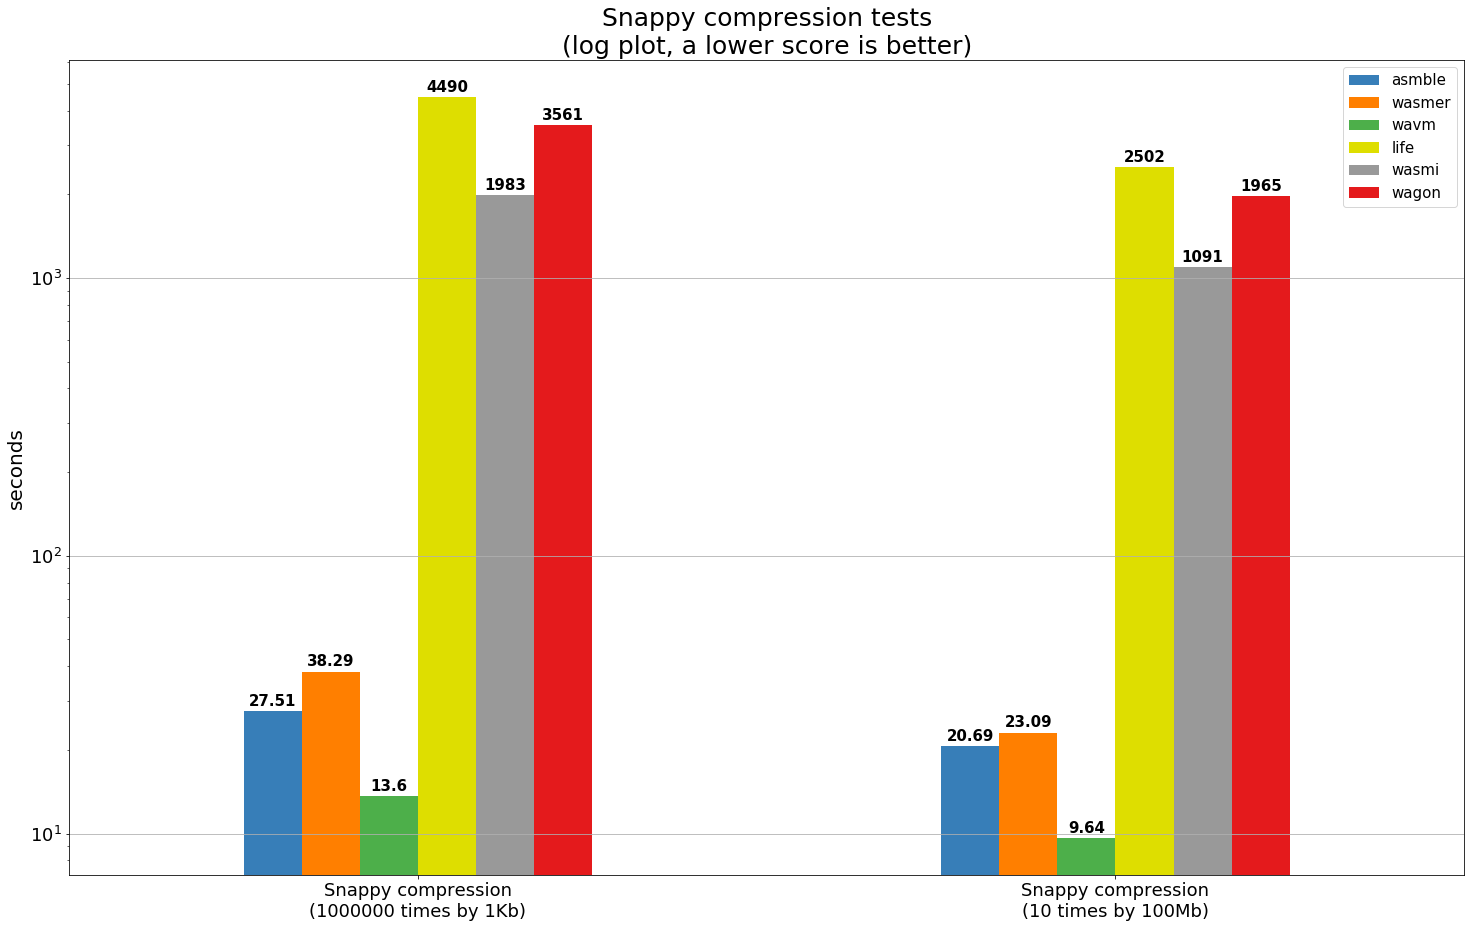

In [9]:
snappy_tests = pd.DataFrame([test_results["snappy_compression_5_1000000_1Kb"].mean(),
                             test_results["snappy_compression_5_10_100Mb"].mean()],
                             index=["Snappy compression\n(1000000 times by 1Kb)",
                                    "Snappy compression\n(10 times by 100Mb)"])

draw_plotbar(snappy_tests, default_figsize, default_fontsize,
             "Snappy compression tests\n(log plot, a lower score is better)")

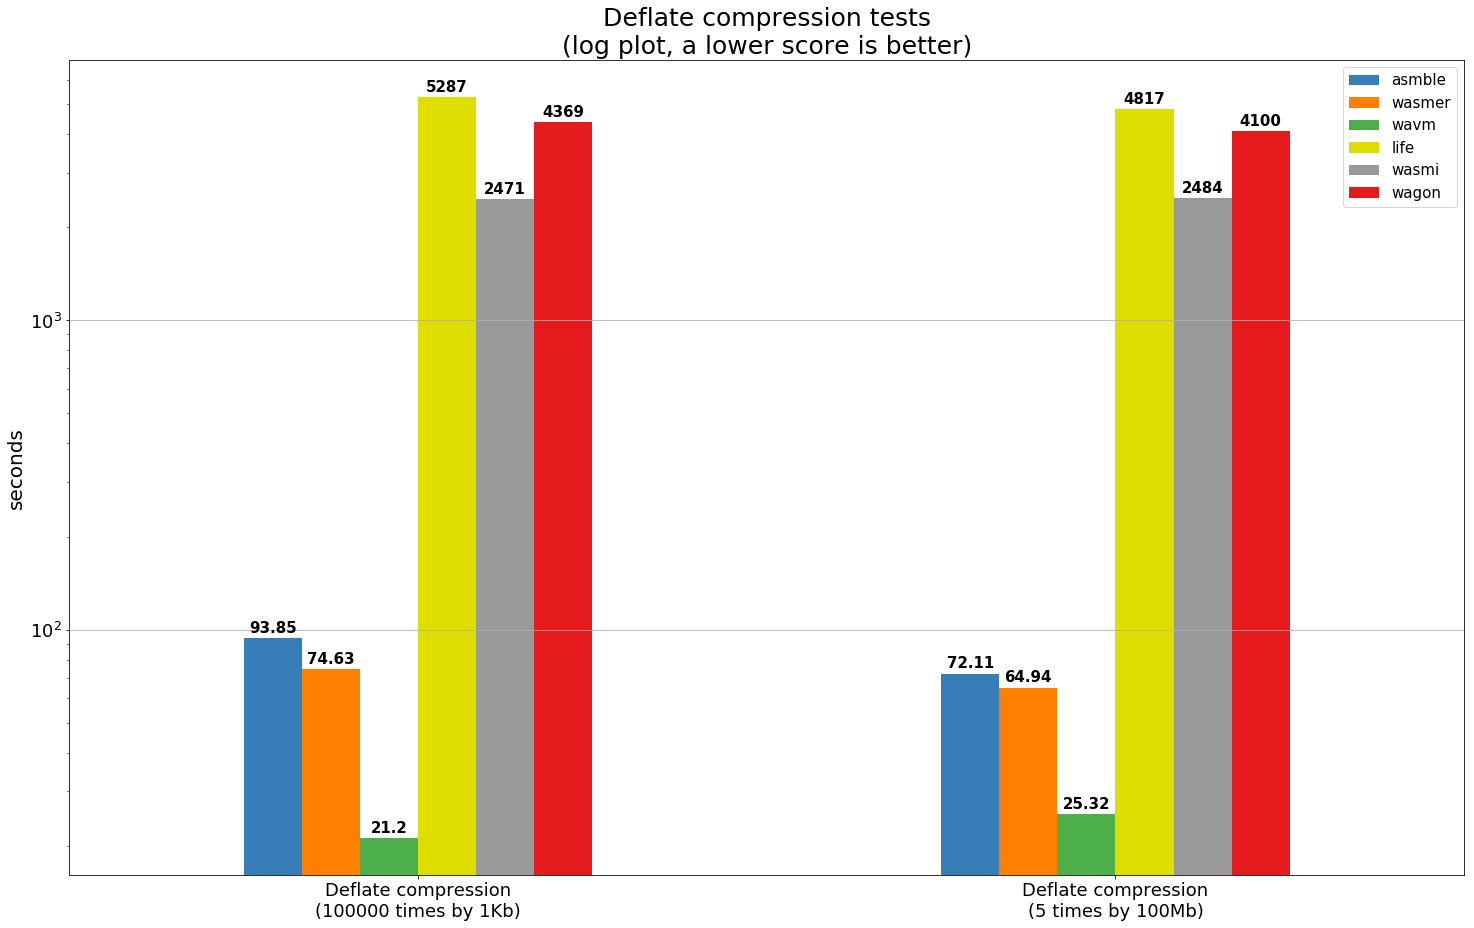

In [10]:
deflate_tests = pd.DataFrame([test_results["deflate_compression_5_100000_1Kb"].mean(),
                              test_results["deflate_compression_5_5_100Mb"].mean()],
                              index=["Deflate compression\n(100000 times by 1Kb)",
                                     "Deflate compression\n(5 times by 100Mb)"])

draw_plotbar(deflate_tests, default_figsize, default_fontsize,
             "Deflate compression tests\n(log plot, a lower score is better)")

<h3>Computation tests</h3>

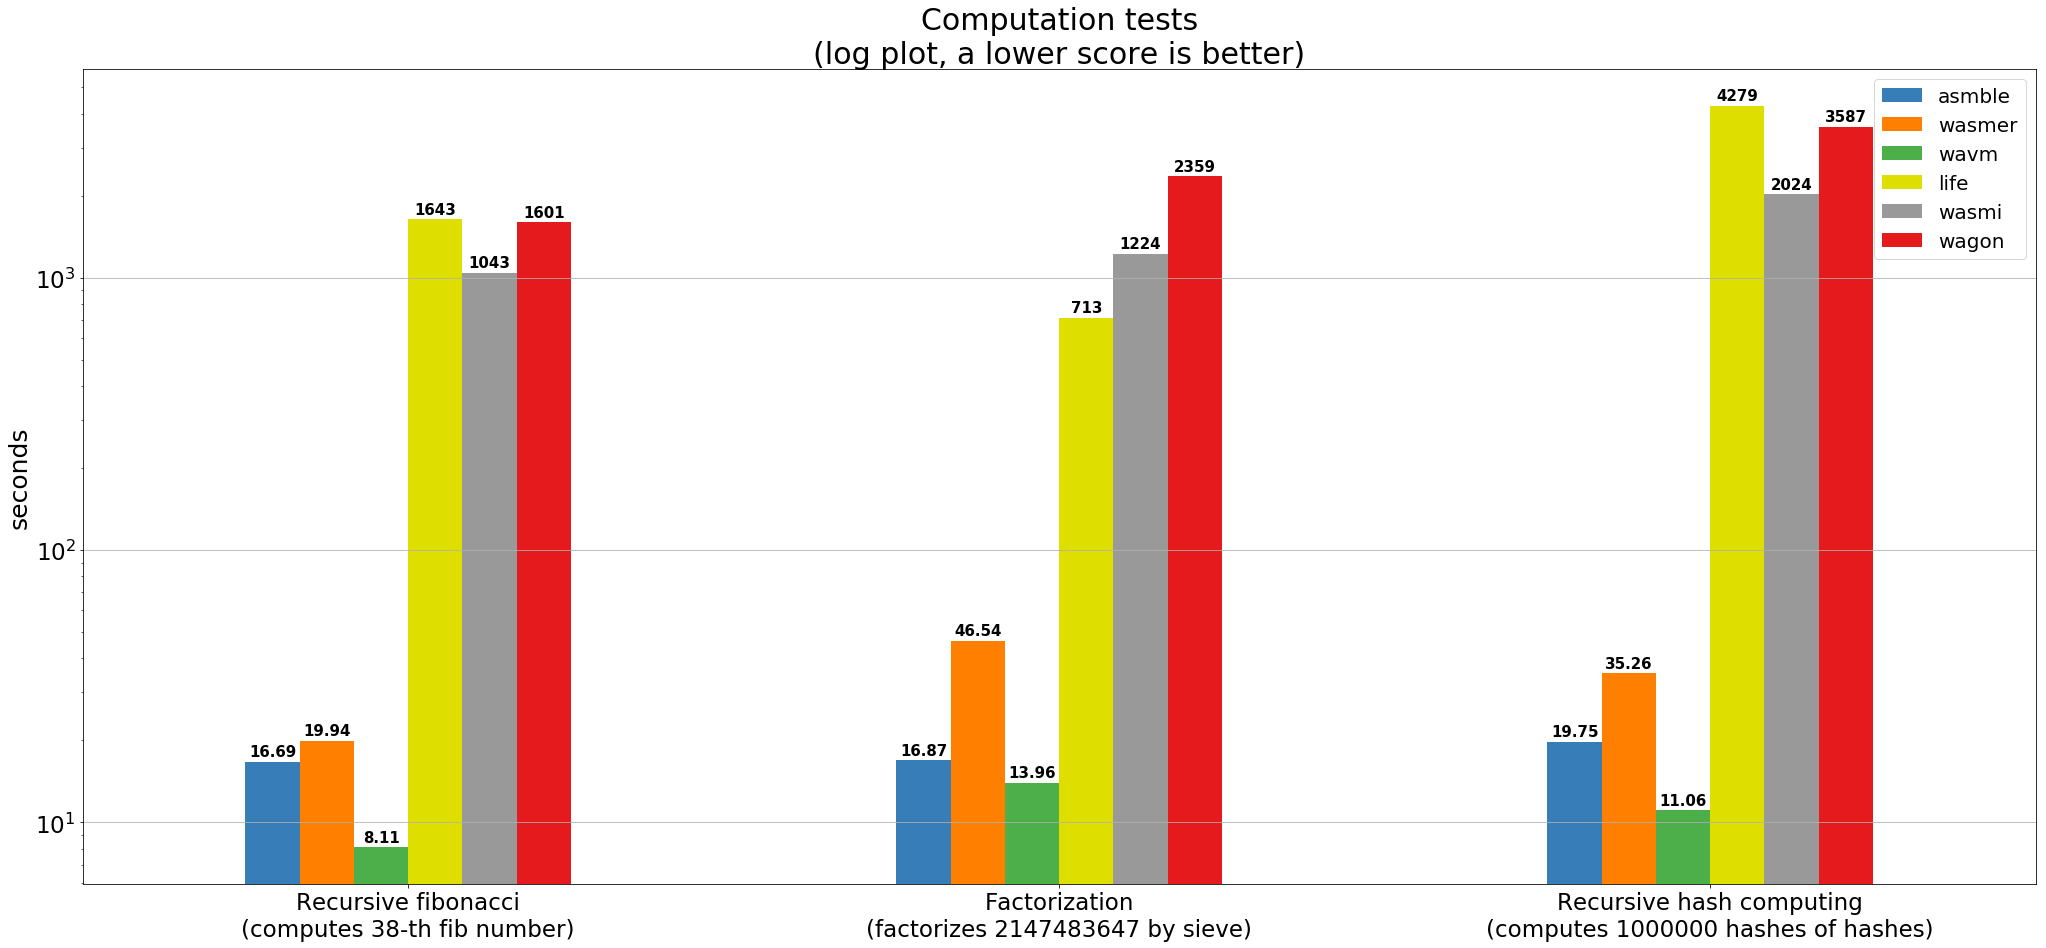

In [11]:
computations_tests = pd.DataFrame([test_results["fibonacci_38"].mean(),
                                   test_results["factorization_2147483647"].mean(),
                                   test_results["recursive_hash_10000000_0"].mean()],
                                  index=["Recursive fibonacci\n(computes 38-th fib number)", 
                                         "Factorization\n(factorizes 2147483647 by sieve)",
                                         "Recursive hash computing\n(computes 1000000 hashes of hashes)"])

draw_plotbar(computations_tests, (35,15), 20, "Computation tests\n(log plot, a lower score is better)")

<h3>Matrix tests</h3>

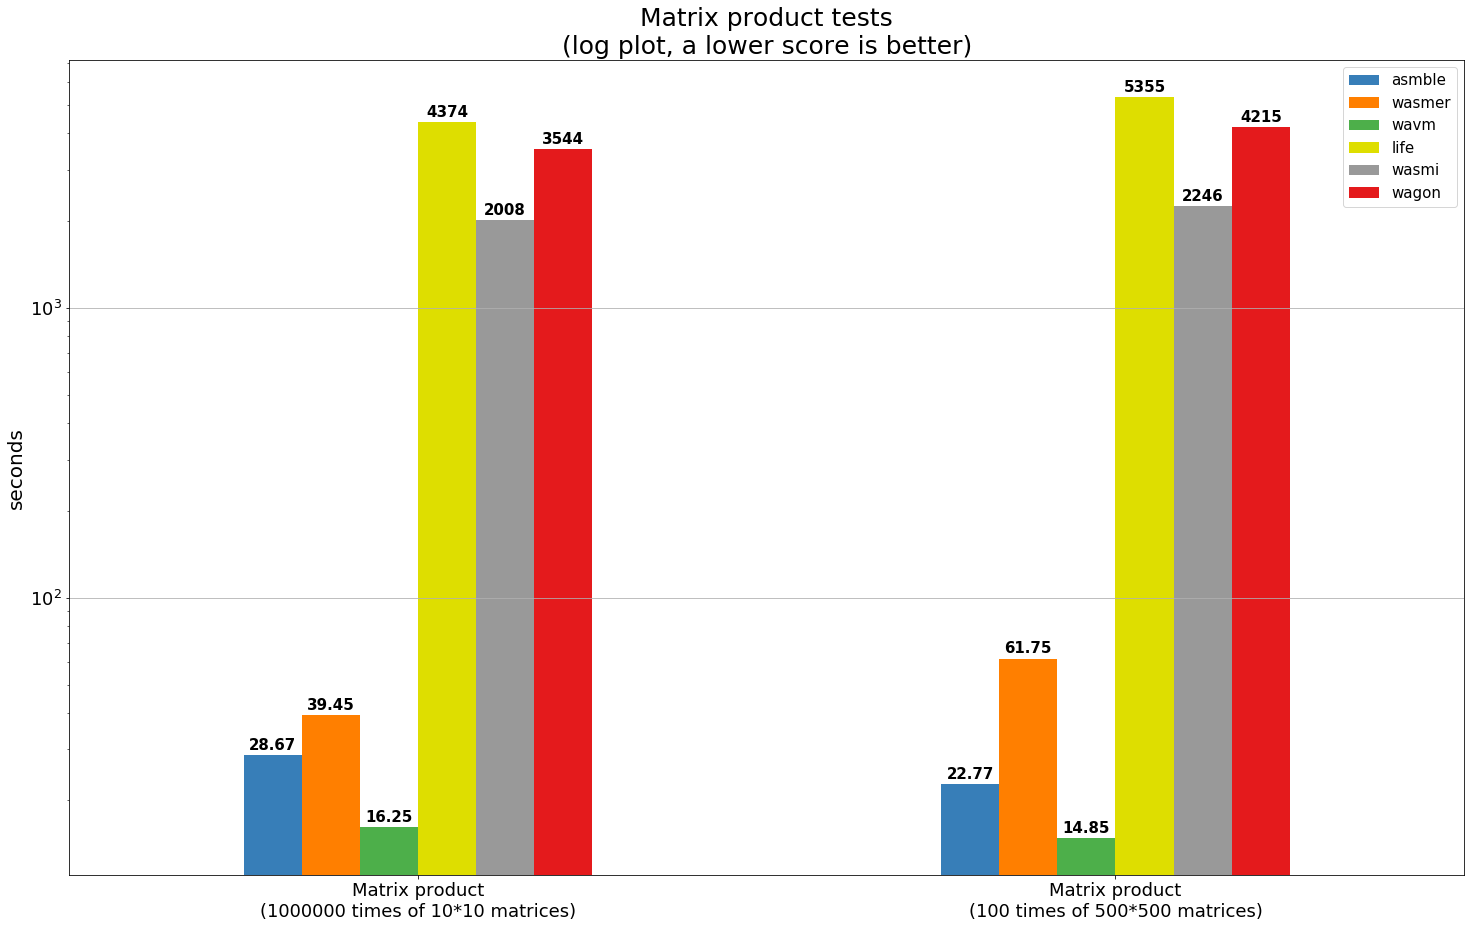

In [12]:
matrix_product = pd.DataFrame([test_results["matrix_product_1_10_1000000"].mean(),
                               test_results["matrix_product_1_500_100"].mean()],
                              index=["Matrix product\n(1000000 times of 10*10 matrices)",
                                     "Matrix product\n(100 times of 500*500 matrices)"])

draw_plotbar(matrix_product, default_figsize, default_fontsize,
             "Matrix product tests\n(log plot, a lower score is better)")

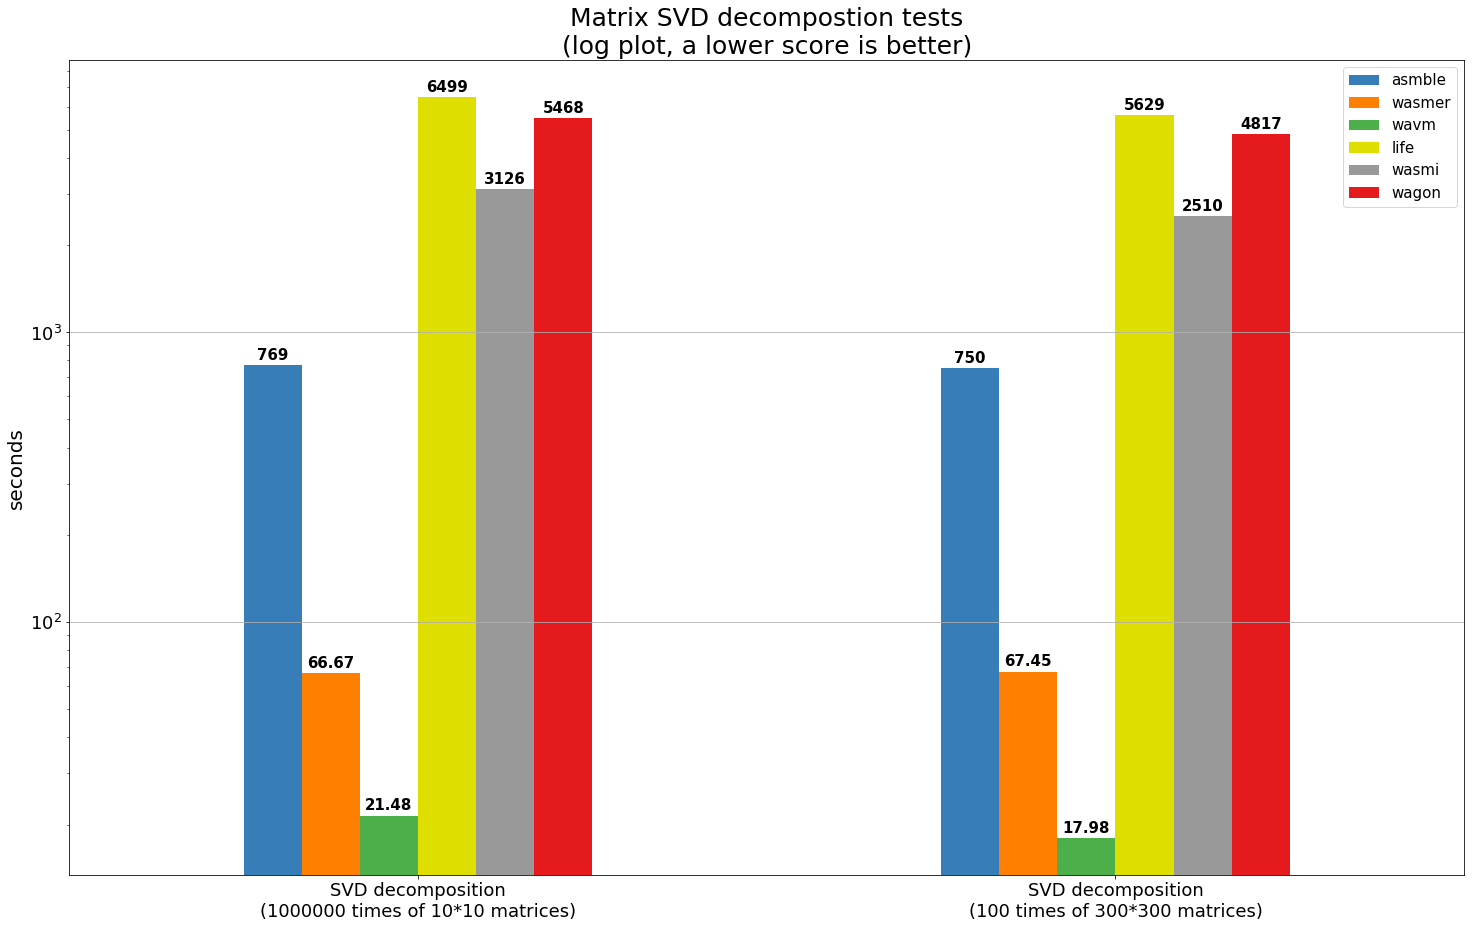

In [13]:
svd_decomposition = pd.DataFrame([test_results["svd_decomposition_1_10_1000000"].mean(),
                                  test_results["svd_decomposition_1_300_100"].mean()],
                                 index=["SVD decomposition\n(1000000 times of 10*10 matrices)",
                                        "SVD decomposition\n(100 times of 300*300 matrices)"])

draw_plotbar(svd_decomposition, default_figsize, default_fontsize,
             "Matrix SVD decompostion tests\n(log plot, a lower score is better)")

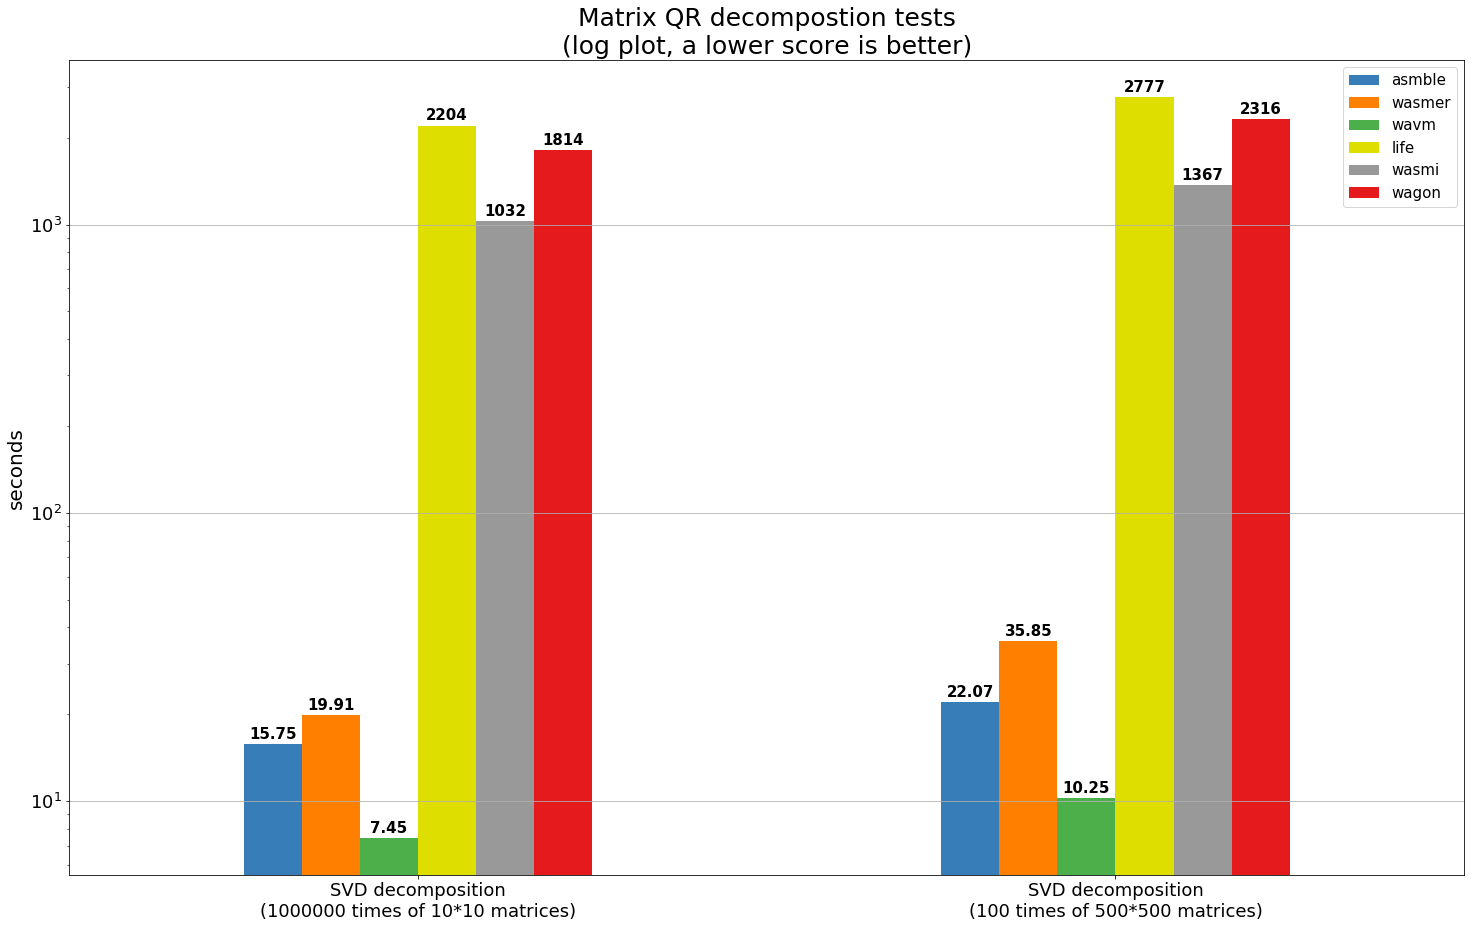

In [14]:
qr_decomposition = pd.DataFrame([test_results["qr_decomposition_1_10_1000000"].mean(),
                                 test_results["qr_decomposition_1_500_100"].mean()],
                                index=["SVD decomposition\n(1000000 times of 10*10 matrices)",
                                       "SVD decomposition\n(100 times of 500*500 matrices)"])

draw_plotbar(qr_decomposition, default_figsize, default_fontsize,
             "Matrix QR decompostion tests\n(log plot, a lower score is better)")